PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


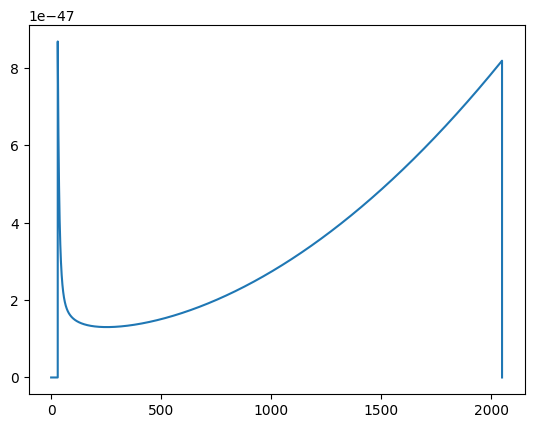

In [1]:
import numpy as np
import pycbc.noise
import pycbc.psd
import matplotlib.pyplot as plt

flow=30.0
delta_f=1.0/16
flen=int(2048/delta_f)+1

psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

plt.plot(psd.sample_frequencies, psd)
plt.show()



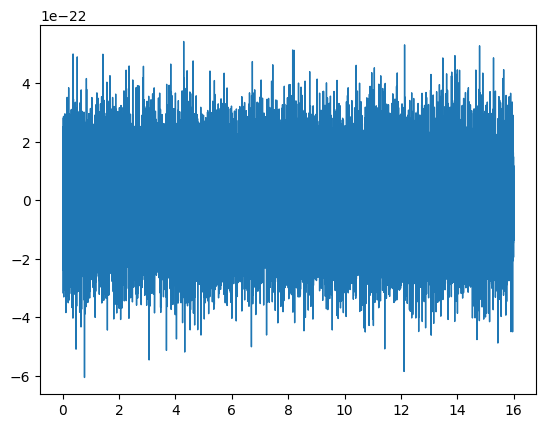

In [2]:
delta_t=1/2048
t_samples=int(16/delta_t)


ts = pycbc.noise.gaussian.noise_from_psd(t_samples, delta_t, psd, seed=127)

plt.plot(ts.sample_times, ts, linewidth=1)
plt.show()




-0.414515456460921
-0.6051033320845963


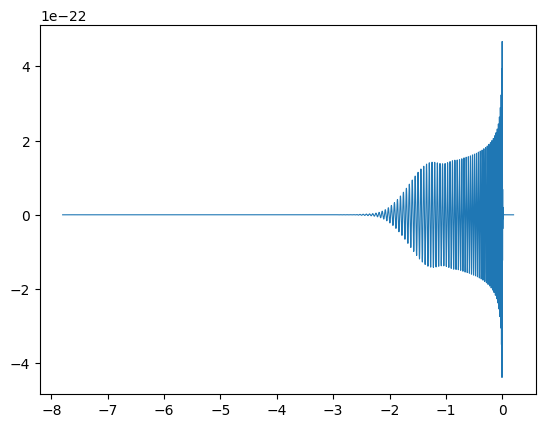

In [31]:
from pycbc.detector import Detector
from pycbc.waveform import get_td_waveform

hp, hc = get_td_waveform(approximant='IMRPhenomD', mass1=10, mass2=50, distance=800, f_lower=20, delta_t=delta_t)

plt.plot(hp.sample_times, hp, label='IMRPhenomD', linewidth=0.8)
#plt.show()


#get antenna patterns
ra=2.3
dec=1.7
t_gps=100000


det = Detector('H1') 

fp, fc = det.antenna_pattern(ra, dec, polarization=0.5, t_gps=t_gps)

print(fp)
print(fc)

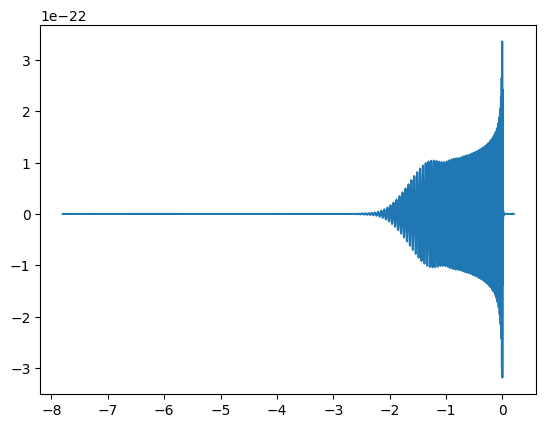

In [4]:
ht = fp*hp + fc*hc

plt.plot(ht.sample_times, ht)
plt.show()

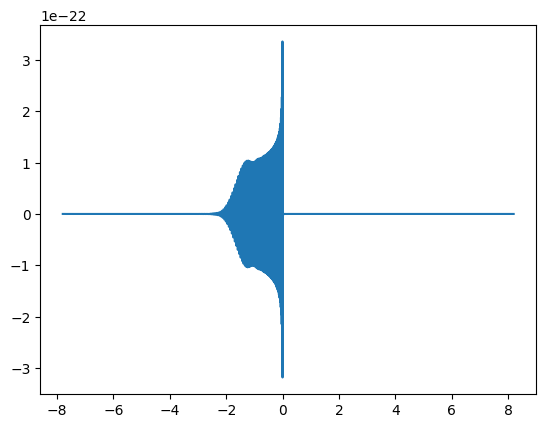

In [5]:
ht.resize(len(ts))


plt.plot(ht.sample_times, ht)
plt.show()

0
16
16.0


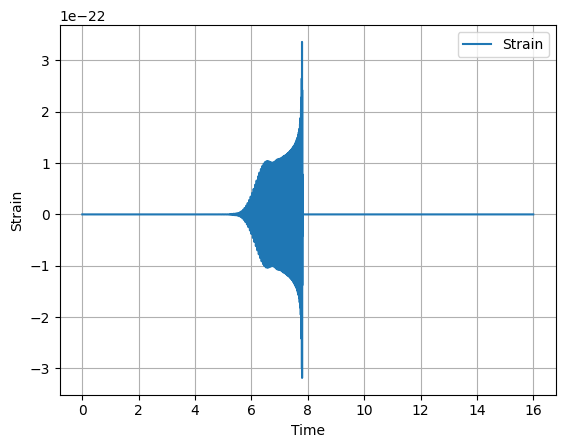

In [6]:
ht.start_time = ts.start_time
print (ht.start_time)
print (ht.end_time)
print(ht.duration)


plt.plot(ht.sample_times, ht, label='Strain')
plt.legend()
plt.ylabel('Strain')
plt.xlabel('Time')
plt.grid()
plt.show()

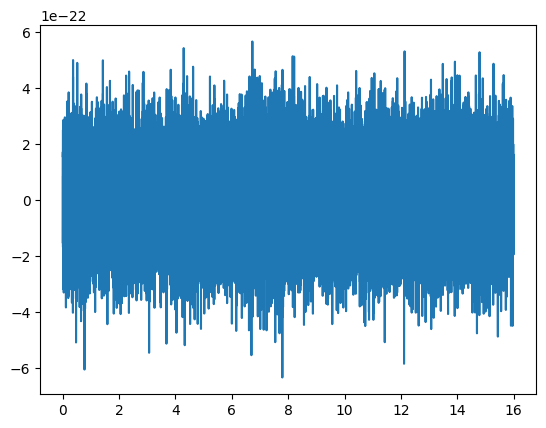

In [7]:
sig = ts + ht

plt.plot(sig.sample_times, sig)
plt.show()

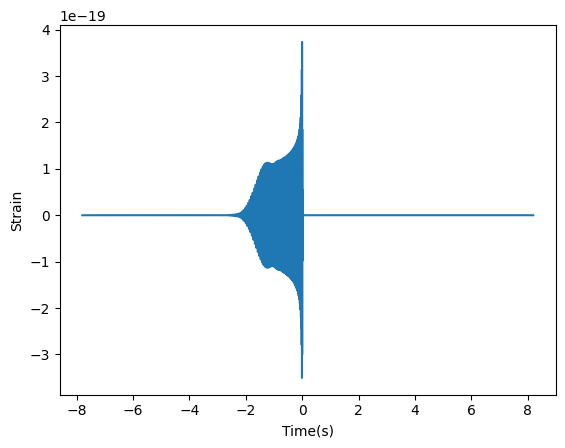

-7.8
8.2
16.0


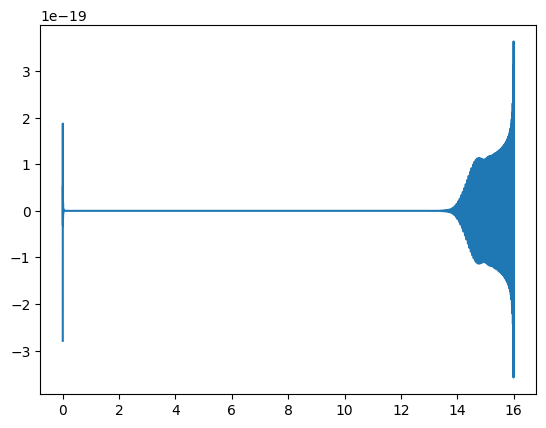

In [8]:
hpt, hct= get_td_waveform(approximant="IMRPhenomD", mass1=10, mass2=50, delta_t=sig.delta_t, f_lower=20)

# Resizing the vector to match the data
hpt.resize(len(sig))
plt.plot(hpt.sample_times,hpt)
#plt.xlim(-2,1)
plt.xlabel('Time(s)')
plt.ylabel('Strain')
plt.show()



print (hpt.start_time)
print (hpt.end_time)
print (hpt.duration)

template = hpt.cyclic_time_shift(hpt.start_time)
plt.plot(template.sample_times,template)
plt.show()



(30, 1024)

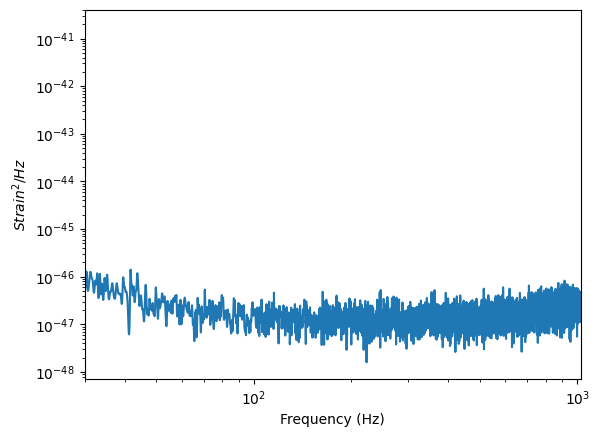

In [9]:
conditioned = sig

from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

psd = interpolate(psd, conditioned.delta_f)

psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate), low_frequency_cutoff=30)

plt.loglog(psd.sample_frequencies, psd)
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
plt.xlim(30, 1024)

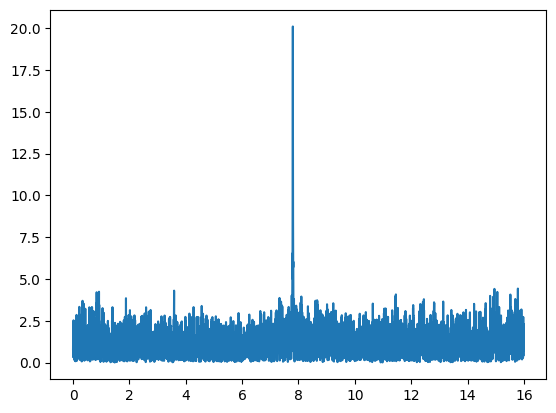

In [10]:
from pycbc.filter import matched_filter

snr = matched_filter(template, sig, psd=psd, low_frequency_cutoff=20)

plt.plot(snr.sample_times, abs(snr))
plt.show()

In [27]:
b = 0.72*pycbc.pnutils.get_freq('fSEOBNRv4Peak', 10, 50, 0.0, 0.0)**0.7

print(b)

26.184645081505376


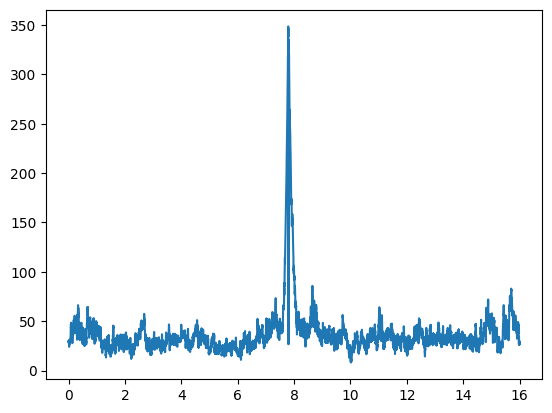

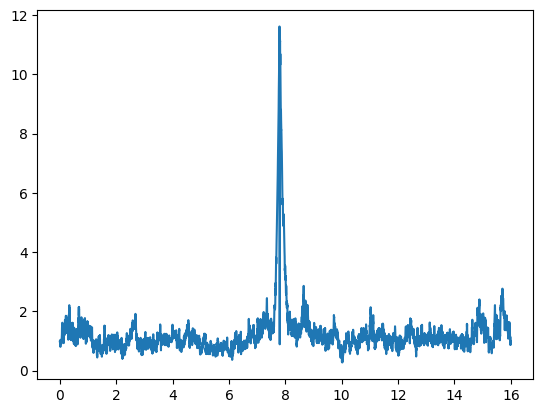

In [40]:
import pycbc.vetoes
import pycbc.waveform
import pycbc.psd
import pycbc.filter
import pycbc.types



sig_f=sig.to_frequencyseries()
template_f=template.to_frequencyseries()

num_bins=16

chisq= pycbc.vetoes.power_chisq(template_f, sig_f, psd = psd, num_bins=16, low_frequency_cutoff=30.0)


red_chisq = chisq/(2*num_bins - 2)

plt.plot(chisq.sample_times, chisq)
plt.show()

plt.plot(red_chisq.sample_times, red_chisq)
plt.show()

In [80]:
new_snr_arr=snr*0

def new_snr(snr, red_chisq):

    if red_chisq > 1:
        return snr/((1 + red_chisq**3)/2)**(1/6)
    else:
        return snr
    
for i in range(len(new_snr_arr)):
    new_snr_arr[i]= new_snr(snr[i], red_chisq[i])


plt.plot(chisq.sample_times, new_snr_arr)
plt.show()